# Fraud Detection

## Finding the People of Interest and Indicative Email Language

### The Enron Corporation
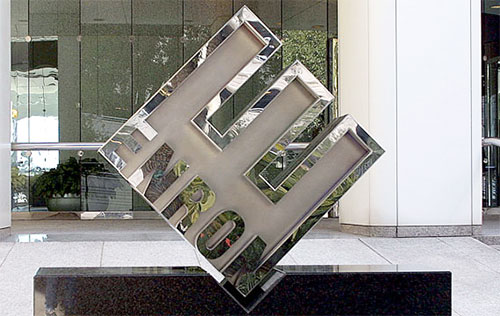


The Enron Corporation was an American energy company based in Houston, Texas formed in 1985 by Kenneth Lay after merging Houston Natural Gas and InterNorth.  The Enron scandal, initially made public in the fall of 2001, eventually led to the bankruptcy of the Enron Corporation.  The case led not only to the dissolution of Enron, but also the de facto dissolution of Arthur Andersen, one of the five largest accountancy firms in the world at the time.  Additionally, the case caused financial distress thoughtout the energy, trading and financial markets, ultimately leading to the implementation of the Sarbanes-Oxley Act in the US.   In 2001, it was the largest bankruptcy reorganization in American history, though that title was shortlived, with the collapse of Worldcom the following year. Nearly twenty years later the effects of the collapse are still felt in the financial and energy markets.  Given the enormous scope of the corporate failure in risk mangement, auditor oversight, and corporate culture, the red flags that were visible are worth ongoing investigation.


### The Enron Emails

The dataset we are reviewing is the remaining body of corporate emails mostly between 1997-2001.  The remaining body contains data from about 150 users, mostly senior management of Enron, and contains over 500k individual emails.  This data was originally made public,  by the Federal Energy Regulatory Commission during its investigation. You can find the source data here.  It was not included in the repository due to its size.
https://www.cs.cmu.edu/~enron/


### The Question

We will be using both the email metadata and the emails themselves to indentify the people of interest (POI) requiring further investigation.  The process will focus on a two step analysis wherein we will use the ouput of an unsupervised algorithm as the input for a supervised learning algorithm.  __Can we train a model to flag someone as being at risk of committing fraud using their email traffic?__  The project is orangized into 5 notebooks and the reader is requested to review them in order for maximum clarity into the process.  

### Essentially, we will follow the OSEMN process:
 - Obtaining the dataset and loading it into our notebook in part 1
 - Scrubbing the data, text in emails is particularly messy and you will see this done throughout the project though it is focused in part 1 and part 2
 - Exploring the data set suring part 2 and part 3 (and some in part 4) using some traditional methods as well as newer ones, such as word clouds
 - The process is iterative and additional cleaning and exploring will be done in part 4 as prep for our models
 - Modeling with both Unsupervised Machine Learning followed by Modeling with supervised machine learning in part 4
 - Finally, we will interpret our results of the models in part 4 and make recomendations for use cases.

As always we will begin the process by importing the libraries we will need in the first section of the project related to loading the data and cleaning the data.  

In [98]:
import pandas as pd
import numpy as np
import string
from operator import itemgetter
from datetime import datetime
import networkx as nx
import nxviz as nv
import re
import os
from email.parser import Parser
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [99]:
import requests
import pandas
from dateutil import parser
host = 'http://18.188.56.207:9200/'
requests.get(host + '_cat/indices/enron').content

b'yellow open enron oGGvMGBJQ0qeS-0ibeQ_Kg 1 1 251734 28326 628.7mb 628.7mb\n'

In [100]:
def elasticsearch_results_to_df(results):
    '''
    A function that will take the results of a requests.get 
    call to Elasticsearch and return a pandas.DataFrame object 
    with the results 
    '''
    hits = results.json()['hits']['hits']
    data = pandas.DataFrame([i['_source'] for i in hits], index = [i['_id'] for i in hits])
    data['date'] = data['date'].apply(parser.parse)
    return(data)

def print_df_row(row):
    '''
    A function that will take a row of the data frame and print it out
    '''
    print('____________________')
    print('RE: %s' % row.get('subject',''))
    print('At: %s' % row.get('date',''))
    print('From: %s' % row.get('sender',''))
    print('To: %s' % row.get('recipients',''))
    print('CC: %s' % row.get('cc',''))
    print('BCC: %s' % row.get('bcc',''))
    print('Body:\n%s' % row.get('text',''))
    print('____________________')


In [101]:
frames = []
import json
doc = {
    "size": 10000,
    "query" : {
        "match_all" : {}
    },
    "sort": [
        {"date": "asc"}
    ]
}
r=requests.get(host + 'enron/_search', data=json.dumps(doc), headers={'Content-Type':'application/json'})
j = r.json()
length = len(j['hits']['hits'])
lastId = j['hits']['hits'][length-1]['sort'][0]
frames.append(elasticsearch_results_to_df(r))

for i in range(10000, 250000, 10000):
    doc = {
        "size": 10000,
        "query" : {
            "match_all" : {}
        },
        "search_after": [lastId],
        "sort": [
            {"date": "asc"}
        ]
    }
    r=requests.get(host + 'enron/_search', data=json.dumps(doc), headers={'Content-Type':'application/json'})
    j = r.json()
    length = len(j['hits']['hits'])
    lastId = j['hits']['hits'][length-1]['sort'][0]
    frames.append(elasticsearch_results_to_df(r))
# print(len(r.json()['hits']['hits']))

In [102]:
df = pd.concat(frames)
df.rename(columns={"date": "date_time", "text":"body", "sender":"from_field", "recipients":"to_field"}, inplace=True)
df.drop(axis=1, columns=['cc', 'bcc'], inplace=True)
print(df.shape)
df.head()


(250000, 5)


date_time   
226306 1980-01-01 00:00:00+00:00  \
19735  1980-01-01 00:00:00+00:00   
230168 1980-01-01 00:00:00+00:00   
231722 1980-01-01 00:00:00+00:00   
231729 1980-01-01 00:00:00+00:00   

                                                     body   
226306  Andrew -\n\nThanks for your kind words, my fri...  \
19735    OMNIPATH Registration (created by alpwebsrv33...   
230168  The litigation against Ft. James has been sett...   
231722  This email will update you on the status of Pr...   
231729  I put together the following spreadsheet for t...   

                       from_field   
226306   jason.williams@enron.com  \
19735         archiving@enron.com   
230168  richard.sanders@enron.com   
231722     twanda.sweet@enron.com   
231729     stacey.white@enron.com   

                                            to_field   
226306                            thedolan@yahoo.com  \
19735                                            NaN   
230168                       greg.johnston@enron.com   
231722                                           NaN   
231729  steve.gim@enron.com  donald.vinson@enron.com   

                                   subject  
226306                           Re: Bliss  
19735   Archive Log for 5/20/99 1:21:20 PM  
230168               Re: Fort James Canada  
231722                     Project Stanley  
231729                          Dana's VaR

The dataframe is constructed and the next step will be to review some summary statistics so we know where we need to start cleaning.

In [103]:
#basic summary statistics
data = df
data.describe()

date_time    body               from_field   
count                             250000  250000                   250000  \
unique                               NaN  244502                    20220   
top                                  NaN    test  jeff.dasovich@enron.com   
freq                                 NaN      40                     5497   
mean    2001-04-24 04:42:15.806992+00:00     NaN                      NaN   
min            1980-01-01 00:00:00+00:00     NaN                      NaN   
25%            2000-12-05 11:02:30+00:00     NaN                      NaN   
50%            2001-05-24 20:37:07+00:00     NaN                      NaN   
75%     2001-10-26 20:31:31.500000+00:00     NaN                      NaN   
max            2002-04-29 15:49:00+00:00     NaN                      NaN   

                    to_field subject  
count                 240792  250000  
unique                 57963  158065  
top     pete.davis@enron.com          
freq                    3928    8644  
mean                     NaN     NaN  
min                      NaN     NaN  
25%                      NaN     NaN  
50%                      NaN     NaN  
75%                      NaN     NaN  
max                      NaN     NaN

In [104]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250000 entries, 226306 to 58734
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype                  
---  ------      --------------   -----                  
 0   date_time   250000 non-null  datetime64[ns, tzutc()]
 1   body        250000 non-null  object                 
 2   from_field  250000 non-null  object                 
 3   to_field    240792 non-null  object                 
 4   subject     250000 non-null  object                 
dtypes: datetime64[ns, tzutc()](1), object(4)
memory usage: 11.4+ MB


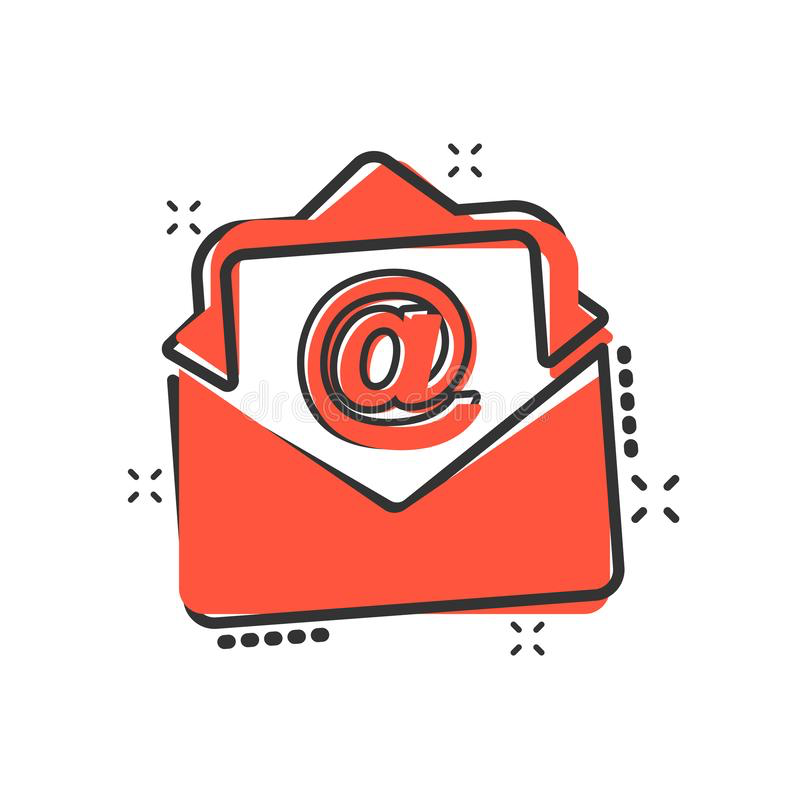

If we get rid of the blank \"to:\" fields, then we remove just under 5% of the total dataset.  This may seem like a lot, however we still have over 495,000 emails.  We will drop those rows and reset the index so it is continuous.

In [105]:
df = data.dropna()
df = df.reset_index(drop=True)

We can also save this Data Frame to a .csv in case we need it later.

In [106]:
df.to_csv(r'./df.csv', index=False)

One of the other things that we need to work on is the date column.  It's currently stored as text and has a lot of other information (like the time zone) that we do not need.  We will have to clean it up a little before we can change it to a datetime object.

In [107]:
#removing the timezone data since we don't need it
#then reformatting the Series to datetime
start = datetime.now()
# for i in range(0,len(df['date_time'])):
#     if i % 10000 == 0:
#         print(datetime.now())
#     df['date_time'][i] = df['date_time'][i][:-12]
#     df.date_time[i] = datetime.strptime(df['date_time'][i], '%a, %d %b %Y %H:%M:%S')
finish = datetime.now()
elapsed = finish-start
print("{} has elapsed.".format(elapsed))

0:00:00 has elapsed.


In [108]:
#coercing the column to the proper format
clean_date = pd.to_datetime(df.date_time, errors= 'coerce')


In [109]:
#checking to see if the code executed properly
clean_date.head()

0   1980-01-01 00:00:00+00:00
1   1980-01-01 00:00:00+00:00
2   1980-01-01 00:00:00+00:00
3   1980-01-01 00:00:00+00:00
4   1980-01-01 00:00:00+00:00
Name: date_time, dtype: datetime64[ns, tzutc()]

In [110]:
#adding the date column back to the dataframe
df['dates']= clean_date.values

In [111]:
#checking the summary statistics to ensure that the formatting worked
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240792 entries, 0 to 240791
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype                  
---  ------      --------------   -----                  
 0   date_time   240792 non-null  datetime64[ns, tzutc()]
 1   body        240792 non-null  object                 
 2   from_field  240792 non-null  object                 
 3   to_field    240792 non-null  object                 
 4   subject     240792 non-null  object                 
 5   dates       240792 non-null  datetime64[ns]         
dtypes: datetime64[ns, tzutc()](1), datetime64[ns](1), object(4)
memory usage: 11.0+ MB


Now that the date is a datetime object, we can use the datetime methods to reformat the dates.  This is a rexrouce intensive loop, so we will add a timer/counter to make sure it is working.
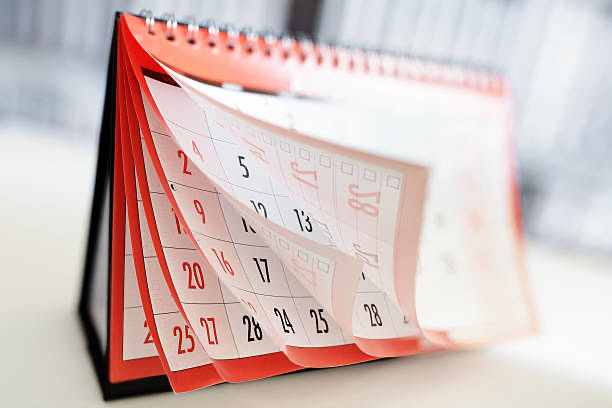

In [112]:
start = datetime.now()
for i in range(0, len(df.dates)):
    if i % 10000 == 0:
        print(datetime.now())
        
        if pd.isnull(df['dates'][i]):
            df['dates'][i] = 0
        else:
            df['dates'][i]=datetime.strftime(df['dates'][i],format ='%Y-%B-%d')
finish = datetime.now()
elapsed = finish-start
print("{} has elapsed.".format(elapsed))

2023-11-20 19:13:34.172720
2023-11-20 19:13:34.176732
2023-11-20 19:13:34.178751
2023-11-20 19:13:34.179772
2023-11-20 19:13:34.181067
2023-11-20 19:13:34.182113
2023-11-20 19:13:34.183105
2023-11-20 19:13:34.184071
2023-11-20 19:13:34.185072
2023-11-20 19:13:34.187062
2023-11-20 19:13:34.187062
2023-11-20 19:13:34.189131
2023-11-20 19:13:34.190111
2023-11-20 19:13:34.191071
2023-11-20 19:13:34.192070
2023-11-20 19:13:34.193071
2023-11-20 19:13:34.194114
2023-11-20 19:13:34.195107
2023-11-20 19:13:34.197064
2023-11-20 19:13:34.198113
2023-11-20 19:13:34.199113
2023-11-20 19:13:34.200114
2023-11-20 19:13:34.201113
2023-11-20 19:13:34.202119
2023-11-20 19:13:34.203081
0:00:00.030361 has elapsed.


In [113]:
df.head()

date_time   
0 1980-01-01 00:00:00+00:00  \
1 1980-01-01 00:00:00+00:00   
2 1980-01-01 00:00:00+00:00   
3 1980-01-01 00:00:00+00:00   
4 1980-01-01 00:00:00+00:00   

                                                body   
0  Andrew -\n\nThanks for your kind words, my fri...  \
1  The litigation against Ft. James has been sett...   
2  I put together the following spreadsheet for t...   
3  Jeff,\n\nThought you might appreciate this.\n\...   
4  I have set aside my afternoon today to complet...   

                  from_field                                      to_field   
0   jason.williams@enron.com                            thedolan@yahoo.com  \
1  richard.sanders@enron.com                       greg.johnston@enron.com   
2     stacey.white@enron.com  steve.gim@enron.com  donald.vinson@enron.com   
3   kevin.ruscitti@enron.com                     jjcardiff@duke-energy.com   
4       sally.beck@enron.com                          greg.piper@enron.com   

                       subject      dates  
0                    Re: Bliss 1980-01-01  
1        Re: Fort James Canada 1980-01-01  
2                   Dana's VaR 1980-01-01  
3      Re: California Dreamin' 1980-01-01  
4  RE: Update on Confirm Logic 1980-01-01

That didn't quite get the date format exactly as we exepcted.  We can try another method for formating that series.

In [114]:
#forcing the date column to a date time format
df['dates'] = pd.to_datetime(df['dates'],infer_datetime_format=True)
df['date'] = df['dates'].dt.date


In [115]:
#checking the formatting
df['date'].unique()[:10]

array([datetime.date(1980, 1, 1), datetime.date(1986, 4, 26),
       datetime.date(1986, 5, 1), datetime.date(1997, 1, 1),
       datetime.date(1998, 1, 4), datetime.date(1998, 1, 6),
       datetime.date(1998, 5, 27), datetime.date(1998, 9, 1),
       datetime.date(1998, 10, 30), datetime.date(1998, 11, 2)],
      dtype=object)

Now that the dates have been forced into the right format we can plot the emails based on date.

In [116]:
#creating a dictionary for the dates and the count of the emails sent on the same day
date_dict= {}
set_dates = set(list(df.date))
for i in set_dates:
    date_dict[i]= df.date[df.date == i].value_counts()

In [117]:
#creating the variables for plotting
keys =date_dict.keys()
values =date_dict.values()
#the first item in the list is a NaT which will not be read by matplot below 
x=list(keys)[1:]
y=list(values)[1:]

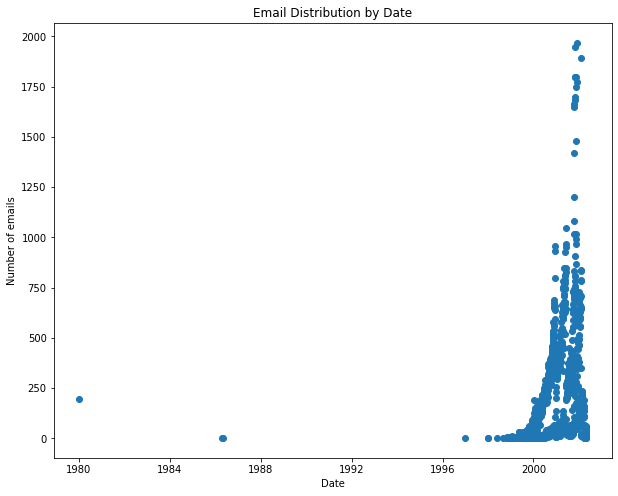

In [118]:
plt.figure(figsize=(10,8)) 
plt.scatter(x,y, label="Email Count")
plt.xlabel('Date') 
plt.ylabel("Number of emails") 
plt.title('Email Distribution by Date') 
plt.show()

This graph shows us a few things.  First, there are a few outlier dates that were likely imported incorrectly or transformed incorrectly.  Second, you can see when the fraud was occurring, the center of mass here is over 2003 which we know to be the time frame of interest.  Let's take the dates and look at them another way.  

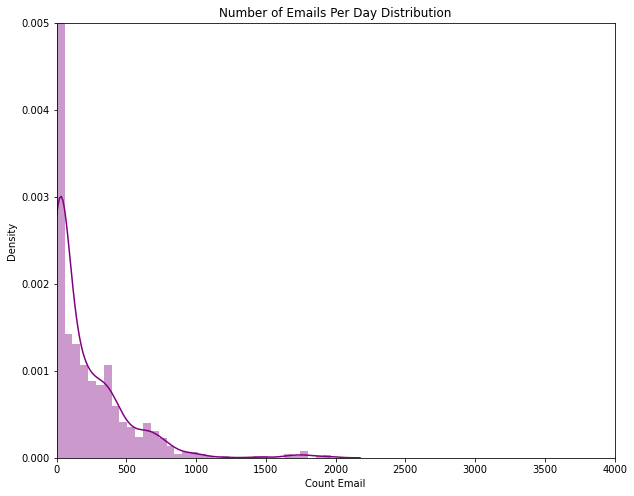

In [119]:
plt.figure(figsize=(10,8))
sns.distplot(y,hist=True, color = 'purple').set(xlim=(0,4000),ylim=(0,0.005))
plt.xlabel("Count Email")
plt.title("Number of Emails Per Day Distribution")
plt.show()

At first glance, this visual tells an unclear story.   I think this  is a nice visualization;  most days had a few emails (well under 500) but there is at least one day where there were over 3000 emails. 

Note that we truncated at 0 because there is no way to have a negative number of sent emails.

Now that we have thouroughly massaged the sent dates on the emails,  we need to switch focus to the \"to:\" field.  Our goal here is to create a network map, and to make a map, we need nodes and direction (namely, from and to). 

Let's pull these out of the dataframe and look at them separately.

In [120]:
#creating a new dataframe
recipients = df.to_field
recipients.head()

0                              thedolan@yahoo.com
1                         greg.johnston@enron.com
2    steve.gim@enron.com  donald.vinson@enron.com
3                       jjcardiff@duke-energy.com
4                            greg.piper@enron.com
Name: to_field, dtype: object

In [121]:
#separating the string of recipients into different columns in the dataframe
recipient_df = recipients.str.split(pat = ' ',expand = True)

In [122]:
#looking at all the recipients
recipient_df.head(3)

0     1                        2     3     4     5      
0       thedolan@yahoo.com  None                     None  None  None  None  \
1  greg.johnston@enron.com  None                     None  None  None  None   
2      steve.gim@enron.com        donald.vinson@enron.com  None  None  None   

   6     7     8     9     ...  2049  2050  2051  2052  2053  2054  2055   
0  None  None  None  None  ...  None  None  None  None  None  None  None  \
1  None  None  None  None  ...  None  None  None  None  None  None  None   
2  None  None  None  None  ...  None  None  None  None  None  None  None   

   2056  2057  2058  
0  None  None  None  
1  None  None  None  
2  None  None  None  

[3 rows x 2059 columns]

In [123]:
recipient_df.shape

(240792, 2059)

These dimensions represent the possible edges in the network map and that is a lot of possible edges; somewhere between 1 million and 500 million.  We will cut it down to the first 3 recipients then we only have about 1.487 million edges.  We will combine that with senders to make a new dataframe for the network maps.

In [124]:
#separating the first 3 series
recipient = recipient_df.iloc[:,0:3]
recipient.head()

0     1                        2
0         thedolan@yahoo.com  None                     None
1    greg.johnston@enron.com  None                     None
2        steve.gim@enron.com        donald.vinson@enron.com
3  jjcardiff@duke-energy.com  None                     None
4       greg.piper@enron.com  None                     None

In [125]:
#renaming columns
recipient.rename(columns={0: "recipient_1", 1: "recipient_2",2:"recipient_3"}, inplace = True)
recipient.head()

recipient_1 recipient_2              recipient_3
0         thedolan@yahoo.com        None                     None
1    greg.johnston@enron.com        None                     None
2        steve.gim@enron.com              donald.vinson@enron.com
3  jjcardiff@duke-energy.com        None                     None
4       greg.piper@enron.com        None                     None

In [127]:
#cleaning up the text
recipient['recipient_3'] = recipient['recipient_3'].str.replace('\n\t','')
recipient['recipient_3'].head()

0                       None
1                       None
2    donald.vinson@enron.com
3                       None
4                       None
Name: recipient_3, dtype: object

In [128]:
recipient['recipient_2'] = recipient['recipient_2'].str.replace('\n\t','')
recipient['recipient_1'] = recipient['recipient_1'].str.replace('\n\t','')
recipient.head(10)

recipient_1 recipient_2              recipient_3
0          thedolan@yahoo.com        None                     None
1     greg.johnston@enron.com        None                     None
2         steve.gim@enron.com              donald.vinson@enron.com
3   jjcardiff@duke-energy.com        None                     None
4        greg.piper@enron.com        None                     None
5          bob.dunn@enron.com        None                     None
6              gramlr@pjm.com        None                     None
7  candace.bywaters@enron.com        None                     None
8  joanna@venturestrategy.com        None                     None
9     philippe.bibi@enron.com              john.lavorato@enron.com


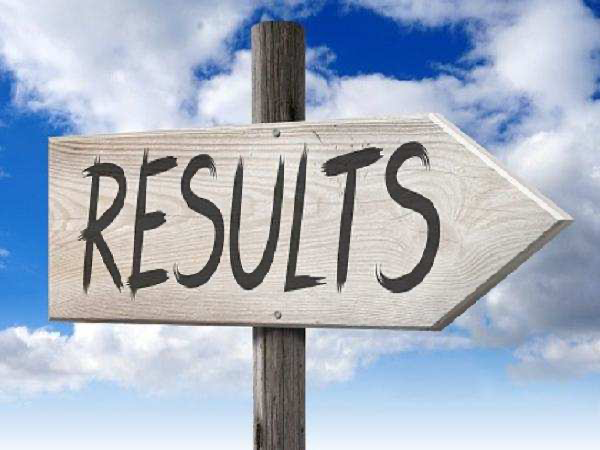

That looks more readable and will serve as the base for the new dataframe.

In [129]:
#creating separte dataframes for merging
sender = df.from_field
dates = df.date
subject = df.subject
body = df.body

result = pd.concat([sender, recipient, dates, subject,body],axis=1, sort=False)


In [130]:
#reviewing the results
result.head()

from_field                recipient_1 recipient_2   
0   jason.williams@enron.com         thedolan@yahoo.com        None  \
1  richard.sanders@enron.com    greg.johnston@enron.com        None   
2     stacey.white@enron.com        steve.gim@enron.com               
3   kevin.ruscitti@enron.com  jjcardiff@duke-energy.com        None   
4       sally.beck@enron.com       greg.piper@enron.com        None   

               recipient_3        date                      subject   
0                     None  1980-01-01                    Re: Bliss  \
1                     None  1980-01-01        Re: Fort James Canada   
2  donald.vinson@enron.com  1980-01-01                   Dana's VaR   
3                     None  1980-01-01      Re: California Dreamin'   
4                     None  1980-01-01  RE: Update on Confirm Logic   

                                                body  
0  Andrew -\n\nThanks for your kind words, my fri...  
1  The litigation against Ft. James has been sett...  
2  I put together the following spreadsheet for t...  
3  Jeff,\n\nThought you might appreciate this.\n\...  
4  I have set aside my afternoon today to complet...

Now that we have the results dataframe we can use it to create some visualizations using networkx, a python library that allows us to review complex networks and nxviz, a visualization packge for networkx.

We will look at three plots here: 

&emsp; __Arc Plot__ - Visualization where by nodes that represent entities are linked by their relationships along a single axis.

&emsp; __Circos Plot__ - Visualization in which nodes are ordered around the circumference of a circle and the edges are drawn within the circle, giving a clear, unclustered view of the network.

&emsp; __Network Map__ - Visualization that positions each node using Fruchterman-Reingold force-directed algorithm.

TypeError: draw() takes 0 positional arguments but 1 was given

<Figure size 720x1080 with 0 Axes>

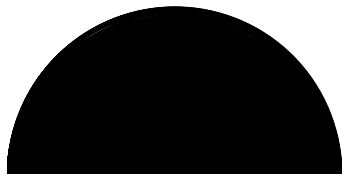

In [131]:
#creating the graph object
G = nx.from_pandas_edgelist(result, source ='from_field', target ='recipient_1', 
                            edge_attr=['subject', 'date'])
# plotting an arcplot
plt.figure(figsize=(10,15))
plot = nv.ArcPlot(G)
plot.draw()
plt.show()

TypeError: draw() takes 0 positional arguments but 1 was given

<Figure size 720x1080 with 0 Axes>

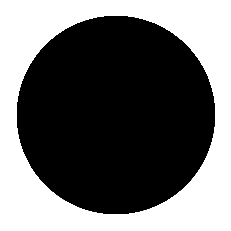

In [132]:
#plotting the Circos plot
plt.figure(figsize=(10,15))
plot = nv.CircosPlot(G)
plot.draw()
plt.show()

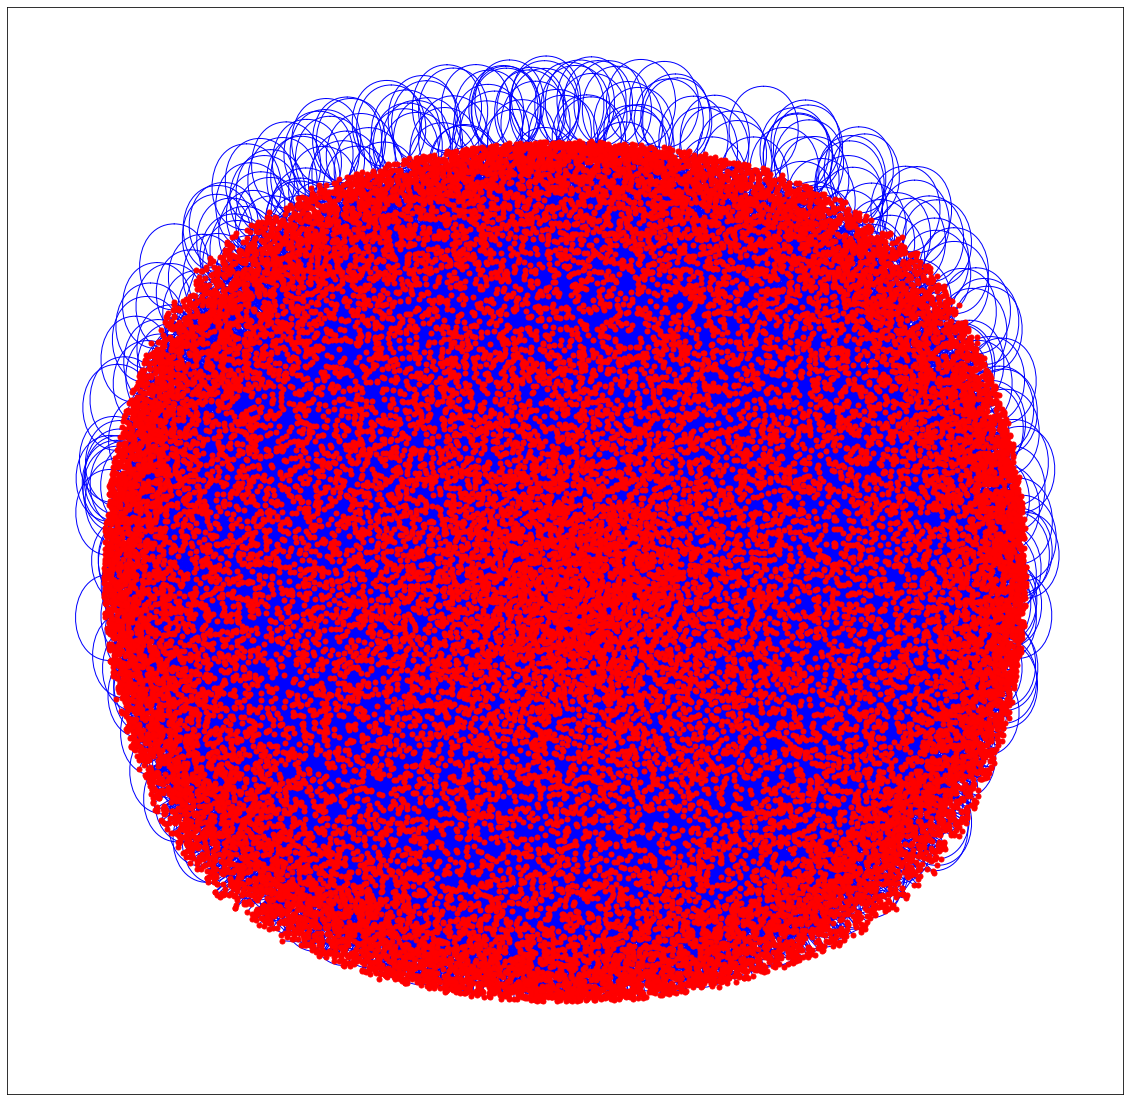

In [133]:
#drawing the network map
plt.figure(figsize=(20,20))
position = nx.spring_layout(G, k=.1)
nx.draw_networkx(G, position, node_size=25, node_color='red', with_labels=False, edge_color='blue')
plt.show()

These are great visualizations, however, taking a look at the full network is so big that it becomes too dense to really see on a regular screen and zooming in limits the view.  We can use the heaviest edges to draw a smaller collection of maps.

In [134]:
#viewing the nodes
G.nodes

NodeView(('jason.williams@enron.com', 'thedolan@yahoo.com', 'richard.sanders@enron.com', 'greg.johnston@enron.com', 'stacey.white@enron.com', 'steve.gim@enron.com', 'kevin.ruscitti@enron.com', 'jjcardiff@duke-energy.com', 'sally.beck@enron.com', 'greg.piper@enron.com', 'eric.bass@enron.com', 'bob.dunn@enron.com', 'jeff.dasovich@enron.com', 'gramlr@pjm.com', 'candace.bywaters@enron.com', 'sherri.sera@enron.com', 'joanna@venturestrategy.com', 'patti.thompson@enron.com', 'philippe.bibi@enron.com', 'kay.mann@enron.com', 'pthompson@akllp.com', 'phillip.allen@enron.com', 'john.lavorato@enron.com', 'tskilling@tribune.com', 'vince.kaminski@enron.com', 'steven.leppard@enron.com', 'jsmith@austintx.com', 'barry.tycholiz@enron.com', 'chris.foster@enron.com', 'william.bradford@enron.com', 'vicki.sharp@enron.com', 'errol.mclaughlin@enron.com', 'bob.shults@enron.com', 'ginger.dernehl@enron.com', 'kate.symes@enron.com', 'scott@darkwing.uoregon.edu', 'anne.koehler@enron.com', 'bonnie.white@enron.com', 

In [135]:
#viewing the edges
G.edges

EdgeView([('jason.williams@enron.com', 'thedolan@yahoo.com'), ('jason.williams@enron.com', 'william.bradford@enron.com'), ('jason.williams@enron.com', 'edward.sacks@enron.com'), ('jason.williams@enron.com', 'kim.ward@enron.com'), ('jason.williams@enron.com', 'john.suttle@enron.com'), ('jason.williams@enron.com', 'rod.nelson@enron.com'), ('jason.williams@enron.com', 'craig.breslau@enron.com'), ('jason.williams@enron.com', 'tanya.rohauer@enron.com'), ('jason.williams@enron.com', 'susan.bailey@enron.com'), ('jason.williams@enron.com', 'msuttle@wunderlichsecurities.com'), ('jason.williams@enron.com', 'drake.borer@utsouthwestern.edu'), ('jason.williams@enron.com', 'derek.bailey@enron.com'), ('jason.williams@enron.com', 'tana.jones@enron.com'), ('jason.williams@enron.com', 'wayne_kearney@ars.aon.com'), ('jason.williams@enron.com', 'kevin.ruscitti@enron.com'), ('jason.williams@enron.com', 'dan.hyvl@enron.com'), ('jason.williams@enron.com', 'stephanie.panus@enron.com'), ('jason.williams@enron.

These lists are enormous, so we'll sort them based on the weight and pick the top # NUMBER

In [136]:
top_edges = sorted(G.edges(data=True), key=lambda t: t[2].get('weight', 1))
top_edges = top_edges[:1000]

In [137]:
len(top_edges)

1000

In [138]:
#creating a new graph object using only the top edges
G2 = nx.from_edgelist(top_edges, create_using=G)


TypeError: draw() takes 0 positional arguments but 1 was given

<Figure size 720x1080 with 0 Axes>

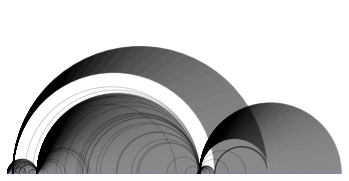

In [139]:
plt.figure(figsize=(10,15))
plot = nv.ArcPlot(G2)
plot.draw()
plt.show()

TypeError: draw() takes 0 positional arguments but 1 was given

<Figure size 720x1080 with 0 Axes>

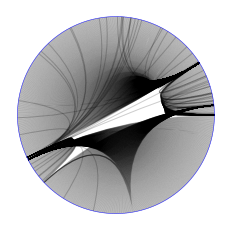

In [140]:
plt.figure(figsize=(10,15))
plot = nv.CircosPlot(G2)
plot.draw()
plt.show()

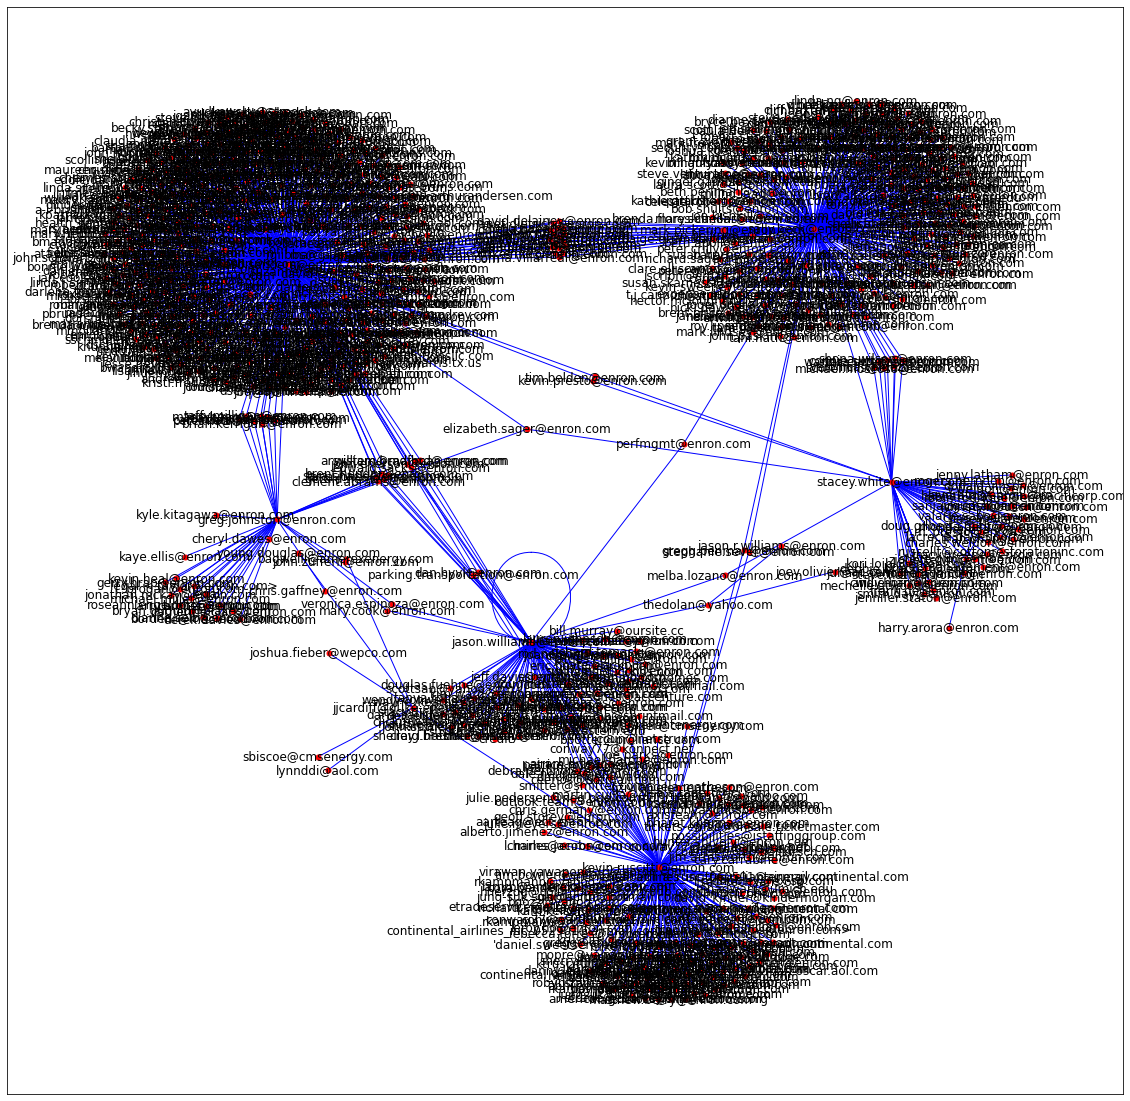

In [141]:
#networkmap with labels
plt.figure(figsize=(20,20))
position = nx.spring_layout(G2, k=.1, scale=2)
nx.draw_networkx(G2, position, node_size=25, node_color='red', with_labels=True, edge_color='blue')
plt.show()

Now that we have a sample from the whole data set we can more easily get a picture of the network.  Ler's look at the shape alone by removing the labels.

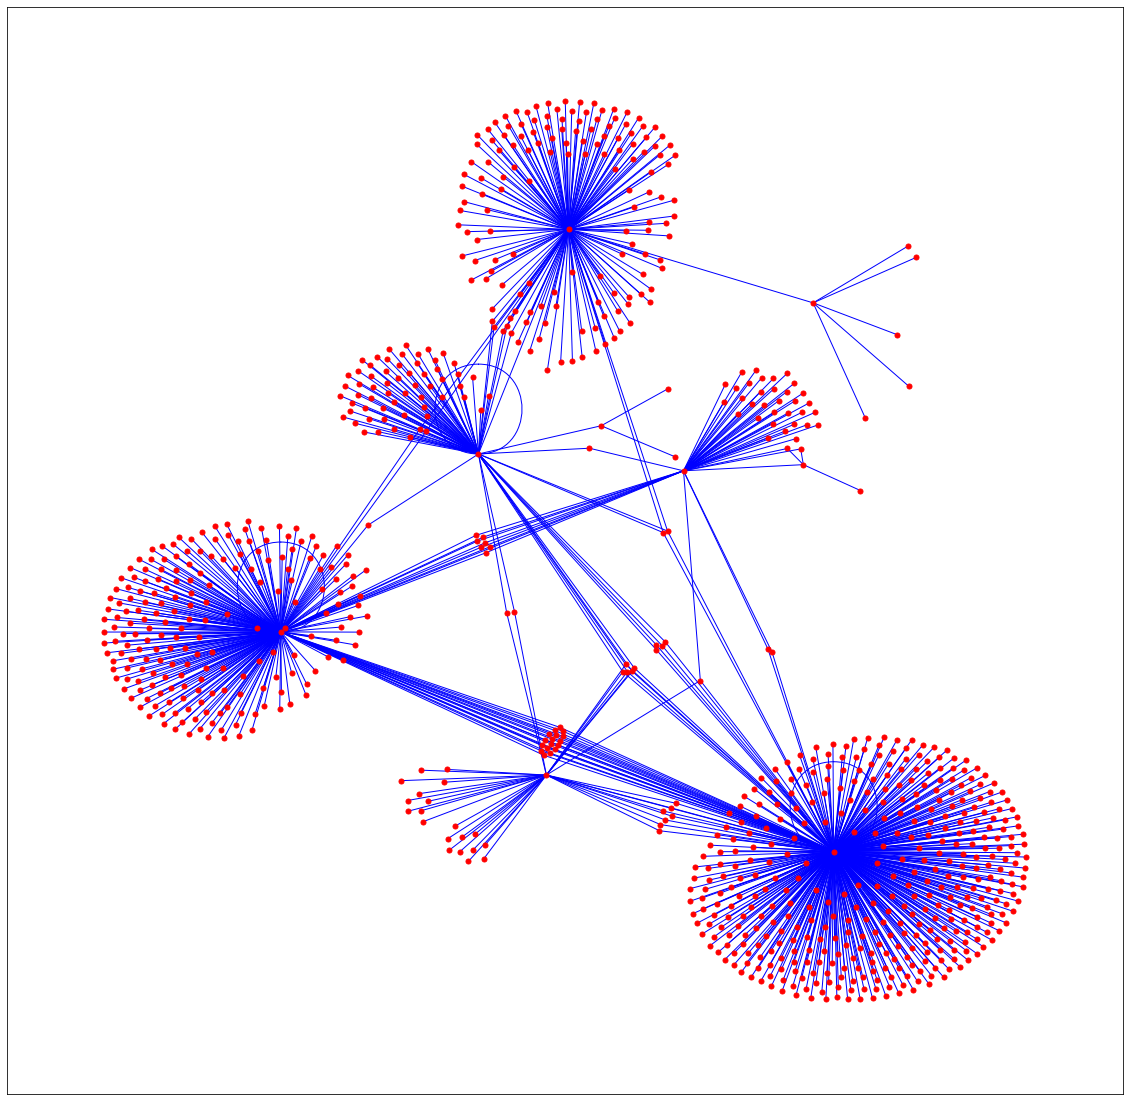

In [142]:
#removing hte labels
plt.figure(figsize=(20,20))
position = nx.spring_layout(G2, k=.1,scale=2)
nx.draw_networkx(G2, position, node_size=25, node_color='red', with_labels=False, edge_color='blue')
plt.show()

John Arnold is at the center (twice actually since he has multiple email addresses).  He was the head of natural gas trading and one of the most prominent traders at the company.  He was awarded one of the largest single bonuses in Enron history (some \$8mm) just days before Enron was forced to declare bankruptcy.

With such a busy map, it can be difficult to see the people at the center.  We can actually find that easily by calculating centrality.  In our case we will use degree centrality.

In [143]:
#calling the degree_centrality method on each graph object
central_nodes_G = nx.algorithms.centrality.degree_centrality(G)
central_nodes_G2 = nx.algorithms.centrality.degree_centrality(G2)

In [144]:
central_nodes_G2

{'jason.williams@enron.com': 0.08788853161843516,
 'thedolan@yahoo.com': 0.003215434083601286,
 'william.bradford@enron.com': 0.0021436227224008574,
 'edward.sacks@enron.com': 0.0021436227224008574,
 'kim.ward@enron.com': 0.0010718113612004287,
 'john.suttle@enron.com': 0.0010718113612004287,
 'rod.nelson@enron.com': 0.0010718113612004287,
 'craig.breslau@enron.com': 0.0010718113612004287,
 'tanya.rohauer@enron.com': 0.0010718113612004287,
 'susan.bailey@enron.com': 0.0010718113612004287,
 'msuttle@wunderlichsecurities.com': 0.0010718113612004287,
 'drake.borer@utsouthwestern.edu': 0.0010718113612004287,
 'derek.bailey@enron.com': 0.0010718113612004287,
 'tana.jones@enron.com': 0.003215434083601286,
 'wayne_kearney@ars.aon.com': 0.0010718113612004287,
 'kevin.ruscitti@enron.com': 0.16720257234726688,
 'dan.hyvl@enron.com': 0.003215434083601286,
 'stephanie.panus@enron.com': 0.0010718113612004287,
 'patrice.mims@enron.com': 0.0021436227224008574,
 'rudwell.johnson@enron.com': 0.00107181

The centrality is sorted as a dictionary in our variable, which means we can find the individual with the highest centrality by looping over the collection.

In [145]:
weight = 0
for key in central_nodes_G:
    val = central_nodes_G[key]
    if val > weight:
        weight = val
        top = key
print("{} is a top emailer with a weight of {}.".format(top, round(weight,9)))

richard.sanders@enron.com is a top emailer with a weight of 0.473740622.


In [146]:
weight2 = 0
for key in central_nodes_G2:
    val = central_nodes_G2[key]
    if val > weight2:
        weight2 = val
        top = key
print("Top emailer, {}, has a with a centrality of {}.".format(top,round(weight2,9)))

Top emailer, richard.sanders@enron.com, has a with a centrality of 0.473740622.


It's great that we were able to construct the network maps, but this won't tell us enough about the people at the company who may have been involved in the ongoing fraud.  We can get the top 50 most active senders and start to narrow down who may have been involved.

In [147]:
#top 50 by taking the set of the sender email counts
top_sender = (lambda x: set(x[:50].index))(result['from_field'].value_counts())
top_sender


{'arsystem@mailman.enron.com',
 'benjamin.rogers@enron.com',
 'bill.williams@enron.com',
 'carol.clair@enron.com',
 'chris.dorland@enron.com',
 'chris.germany@enron.com',
 'd..steffes@enron.com',
 'dan.hyvl@enron.com',
 'daren.farmer@enron.com',
 'darron.giron@enron.com',
 'david.delainey@enron.com',
 'debra.perlingiere@enron.com',
 'drew.fossum@enron.com',
 'elizabeth.sager@enron.com',
 'enron.announcements@enron.com',
 'eric.bass@enron.com',
 'gerald.nemec@enron.com',
 'j.kaminski@enron.com',
 'jeff.dasovich@enron.com',
 'jeffrey.shankman@enron.com',
 'john.arnold@enron.com',
 'john.lavorato@enron.com',
 'kate.symes@enron.com',
 'kay.mann@enron.com',
 'kimberly.watson@enron.com',
 'louise.kitchen@enron.com',
 'lynn.blair@enron.com',
 'm..presto@enron.com',
 'marie.heard@enron.com',
 'mark.haedicke@enron.com',
 'mark.taylor@enron.com',
 'matthew.lenhart@enron.com',
 'michelle.cash@enron.com',
 'mike.grigsby@enron.com',
 'mike.maggi@enron.com',
 'mike.mcconnell@enron.com',
 'pete.davis

Given that there are multiple recipient columns, the collection of the top receivers is a little more complicated, but it follows the same principle.

In [148]:
top_recipient1 = (lambda x: set(x[:30].index))(result['recipient_1'].value_counts())
top_recipient1 = list(top_recipient1)
top_recipient1

['vkaminski@aol.com',
 'louise.kitchen@enron.com',
 'j.kaminski@enron.com',
 'jeff.skilling@enron.com',
 'chris.germany@enron.com',
 'gerald.nemec@enron.com',
 'mike.maggi@enron.com',
 'susan.bailey@enron.com',
 'kate.symes@enron.com',
 'daren.farmer@enron.com',
 'klay@enron.com',
 'benjamin.rogers@enron.com',
 'don.baughman@enron.com',
 'john.lavorato@enron.com',
 'mark.taylor@enron.com',
 'alan.aronowitz@enron.com',
 'rod.hayslett@enron.com',
 'steven.kean@enron.com',
 'pete.davis@enron.com',
 'sally.beck@enron.com',
 'vince.kaminski@enron.com',
 'kenneth.lay@enron.com',
 'jdasovic@enron.com',
 'richard.shapiro@enron.com',
 'sara.shackleton@enron.com',
 'kimberly.watson@enron.com',
 'kay.mann@enron.com',
 'tana.jones@enron.com',
 'elizabeth.sager@enron.com',
 'jeff.dasovich@enron.com']

In [149]:
top_recipient2 = (lambda x: set(x[:30].index))(result['recipient_2'].value_counts())
top_recipient2= list(top_recipient2)
top_recipient2

['',
 '<.brandon@enron.com>',
 '<.cooper@enron.com>',
 '<.angelica@enron.com>',
 '<.brad@enron.com>',
 '<.arthur@enron.com>',
 '<.chris@enron.com>',
 '<.bat@enron.com>',
 '<.ward@enron.com>',
 '<.bill@enron.com>',
 '<.hall@enron.com>',
 '<.andre@enron.com>',
 '<.palmer@enron.com>',
 '<.williams@enron.com>',
 '<.brian@enron.com>',
 '<.angie@enron.com>',
 '<.schuler@enron.com>',
 '<.john@enron.com>',
 '<.alex@enron.com>',
 '<.daniel@enron.com>',
 '<.nelson@enron.com>',
 '<.jeff@enron.com>',
 "<'.'andy@enron.com>",
 '<.ben@enron.com>',
 '<.amy@enron.com>',
 '<.andrea@enron.com>',
 "<'.'andre@enron.com>",
 '<.taylor@enron.com>',
 '<.anita@enron.com>',
 '<.adam@enron.com>']

In [150]:
top_recipient3 = (lambda x: set(x[:30].index))(result['recipient_3'].value_counts())
top_recipient3 = list(top_recipient3)
top_recipient3

['',
 'jeffrey.hodge@enron.com',
 'rick.buy@enron.com',
 'louise.kitchen@enron.com',
 'jeff.skilling@enron.com',
 'chris.germany@enron.com',
 'gerald.nemec@enron.com',
 'susan.bailey@enron.com',
 'susan.mara@enron.com',
 'daren.farmer@enron.com',
 'ggreen2@txu.com',
 'john.lavorato@enron.com',
 'mark.taylor@enron.com',
 'john.arnold@enron.com',
 'greg.whalley@enron.com',
 'samantha.boyd@enron.com',
 'karen.lambert@enron.com',
 'steven.kean@enron.com',
 'sally.beck@enron.com',
 'tim.belden@enron.com',
 'robert.badeer@enron.com',
 'richard.shapiro@enron.com',
 'sara.shackleton@enron.com',
 'kay.mann@enron.com',
 'james.steffes@enron.com',
 'tana.jones@enron.com',
 'elizabeth.sager@enron.com',
 'angela.schwarz@enron.com',
 'jeff.dasovich@enron.com',
 'd..steffes@enron.com']

In [151]:
top_recipients = (top_recipient1+ top_recipient2 + top_recipient3)
top_recipients

['vkaminski@aol.com',
 'louise.kitchen@enron.com',
 'j.kaminski@enron.com',
 'jeff.skilling@enron.com',
 'chris.germany@enron.com',
 'gerald.nemec@enron.com',
 'mike.maggi@enron.com',
 'susan.bailey@enron.com',
 'kate.symes@enron.com',
 'daren.farmer@enron.com',
 'klay@enron.com',
 'benjamin.rogers@enron.com',
 'don.baughman@enron.com',
 'john.lavorato@enron.com',
 'mark.taylor@enron.com',
 'alan.aronowitz@enron.com',
 'rod.hayslett@enron.com',
 'steven.kean@enron.com',
 'pete.davis@enron.com',
 'sally.beck@enron.com',
 'vince.kaminski@enron.com',
 'kenneth.lay@enron.com',
 'jdasovic@enron.com',
 'richard.shapiro@enron.com',
 'sara.shackleton@enron.com',
 'kimberly.watson@enron.com',
 'kay.mann@enron.com',
 'tana.jones@enron.com',
 'elizabeth.sager@enron.com',
 'jeff.dasovich@enron.com',
 '',
 '<.brandon@enron.com>',
 '<.cooper@enron.com>',
 '<.angelica@enron.com>',
 '<.brad@enron.com>',
 '<.arthur@enron.com>',
 '<.chris@enron.com>',
 '<.bat@enron.com>',
 '<.ward@enron.com>',
 '<.bill@

In [152]:
top_recipient = set(top_recipients)
top_recipient = list(top_recipient)
print(top_recipient, "\n\n\nThere are {} top recipients from three reciever series.".format(len(top_recipient)))

['', '<.brandon@enron.com>', 'vkaminski@aol.com', '<.cooper@enron.com>', '<.angelica@enron.com>', 'jeffrey.hodge@enron.com', 'rick.buy@enron.com', '<.taylor@enron.com>', 'louise.kitchen@enron.com', 'j.kaminski@enron.com', 'jeff.skilling@enron.com', 'chris.germany@enron.com', 'gerald.nemec@enron.com', '<.brad@enron.com>', 'mike.maggi@enron.com', 'susan.bailey@enron.com', '<.arthur@enron.com>', 'kate.symes@enron.com', '<.chris@enron.com>', 'susan.mara@enron.com', 'daren.farmer@enron.com', 'klay@enron.com', 'benjamin.rogers@enron.com', 'don.baughman@enron.com', '<.bat@enron.com>', '<.ward@enron.com>', '<.bill@enron.com>', 'ggreen2@txu.com', 'john.lavorato@enron.com', 'mark.taylor@enron.com', '<.andre@enron.com>', 'alan.aronowitz@enron.com', 'john.arnold@enron.com', 'rod.hayslett@enron.com', 'greg.whalley@enron.com', '<.palmer@enron.com>', 'samantha.boyd@enron.com', 'karen.lambert@enron.com', '<.williams@enron.com>', '<.brian@enron.com>', 'steven.kean@enron.com', 'pete.davis@enron.com', 's

We have completed the first section of our analysis: obtaining, cleaning, and some exploring.  We'll store some of the variables that we made so we can use them in other notebooks in the same folder.  

In [62]:
%store top_sender
%store top_recipient
%store result
%store df

Stored 'top_sender' (set)
Stored 'top_recipient' (list)
Stored 'result' (DataFrame)
Stored 'df' (DataFrame)


In [83]:
#saving the result df to a csv
result.to_csv(r'./result.csv', index=False)

### If you'd like to continue please move on to notebook, part 2.